# Classifieur Adaboost
AdaBoost est un modèle d'ensemble qui améliore la performance en séquence en accordant plus de poids aux exemples mal classés. Il combine des classificateurs faibles, comme des arbres de décision peu profonds, pour former un modèle global robuste adapté à la classification.

In [3]:
import DataManagement as DM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

dataset = DM.Dataset('data/train.csv')
dataset.split_data(test_size=0.3, seed=0, stratified=True)
dataset.info()


(693, 192) (297, 192)
##### Informations #####
  - Nb classes   : 99 ( Dim : 192 )
  - Nb samples   : 990
     - Training  : 693 ( 70.0 % )
     - Test      : 297 ( 30.0 % )
########################


Puisque qu'on a beaucoup de classe et très peu de données par classe, on a séparé notre ensemble de données de façon à avoir autant de données dans chaque classe.

## Entrainement

Pour notre classifieur Adaboost, nous utilisons deux hyperparamètres clés :

- base_estimator: c'est le faible 'learner' utilisé pour entrainer le réseau. le DecisionTreeClassifier est utilisé en tant que faible learner par défaut.
- Le nombre d'estimateurs : qui indique le nombre de faible 'learners' à entrainer.
- Le learning rate : qui contribue au poids des faibles 'learners'. la valeur par défaut utilisée est 1.

Bien que le nombre d'estimateur soit souvent l'hyperparamètre le plus crucial, l'impact des autres hyperparamètres sur les performances du modèle sera étudié.

### Recherche des hyperparamètres

On utilise une validation croisée à 5 plis. On utilise un nombre de plis assez petit parce qu'on a très peu de données par classe (seulement 7) et on veut éviter d'avoir des plis qui n'ont pas de données pour certaines classes.

In [32]:

hyperparameters_dt = {
        # Hyperparamètres AdaBoostClassifier
        'n_estimators': range(10, 101, 18),
        'learning_rate': [0.01, 0.1, 1.0],
        'base_estimator': [RandomForestClassifier(), ExtraTreesClassifier(),SVC(probability=True, kernel='linear')],
    }

grid, results = DM.train_model(AdaBoostClassifier(), hyperparameters_dt, dataset)
print('Best:', grid.best_params_, 'with score {:.3}'.format(grid.best_score_))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best: {'base_estimator': ExtraTreesClassifier(), 'learning_rate': 0.01, 'n_estimators': 64} with score 0.974


### Analyse de l'entrainement

Le nombre optimal d'estimateurs (n_estimators) est de 64, ce qui suggère que le modèle Adaboost utilise un ensemble modéré d'estimateurs pour réaliser des prédictions précises sur les espèces de feuilles. En analysant les performances du modèle à ce nombre spécifique d'estimateurs, nous pouvons évaluer l'impact des autres hyperparamètres sur ces résultats.

In [33]:
results[results.param_n_estimators == grid.best_params_['n_estimators']].sort_values(by='rank_test_score')

,param_n_estimators,param_learning_rate,param_base_estimator,mean_test_score,rank_test_score
21,64,0.01,ExtraTreesClassifier(),0.974038,1
15,64,1.0,RandomForestClassifier(),0.972599,3
27,64,0.1,ExtraTreesClassifier(),0.969722,14
33,64,1.0,ExtraTreesClassifier(),0.968262,18
3,64,0.01,RandomForestClassifier(),0.962507,31
9,64,0.1,RandomForestClassifier(),0.962507,31
51,64,1.0,"SVC(kernel='linear', probability=True)",0.500876,40
45,64,0.1,"SVC(kernel='linear', probability=True)",0.399698,45
39,64,0.01,"SVC(kernel='linear', probability=True)",0.129882,50


On remarque que le type de classifieur faible influence grandement la précision. En effet, les classifieurs ExtraTree ont de meilleures performance que le randomForest même si ces dernières reste performantes. Par contre le SVC a de loin les pires performances du lot.

Concernant le learning rate, ses valeurs optimales semble dépendre du type de classifieur faible qui préféreraient soit un plus petit soit un plus grand learning rate. 

On peut tracer un graphique du score en fonction des différentes valeurs d'hyperparamètres pour réellement voir l'impact de leur variation sur le score.

In [34]:
#on convertit dabord les valeurs de la colonne param_base_estimator en chaine de charactères afin de pouvoir de filtrer
#la dataframe
results['param_base_estimator'] = results['param_base_estimator'].astype('str')
grouped = results.groupby('param_base_estimator')

rf_grouped = grouped.get_group('RandomForestClassifier()')
et_grouped = grouped.get_group('ExtraTreesClassifier()')
svc_grouped = grouped.get_group("SVC(kernel='linear', probability=True)")
 

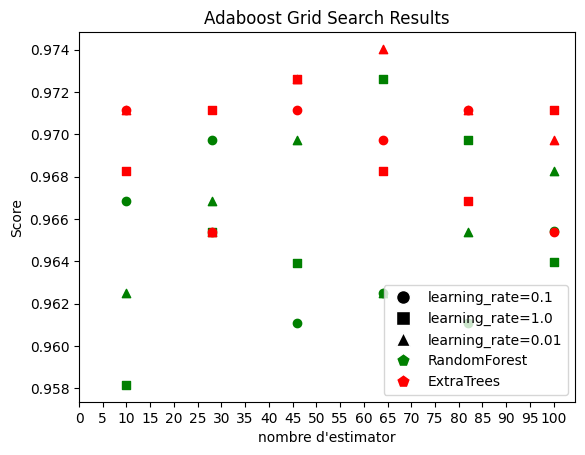

In [35]:
plt.scatter(rf_grouped.query('param_learning_rate == 0.1 ')['param_n_estimators'],
            rf_grouped.query('param_learning_rate == 0.1 ')['mean_test_score'],
            marker='o', color='green', label='learning_rate=0.1, base_estimator=RandomForestClassifier()')
plt.scatter(rf_grouped.query('param_learning_rate == 1.0 ')['param_n_estimators'],
            rf_grouped.query('param_learning_rate == 1.0 ')['mean_test_score'],
            marker='s', color='green', label='learning_rate=1.0, base_estimator=RandomForestClassifier()')
plt.scatter(rf_grouped.query('param_learning_rate == 0.01 ')['param_n_estimators'],
            rf_grouped.query('param_learning_rate == 0.01 ')['mean_test_score'],
            marker='^', color='green', label='learning_rate=0.01, base_estimator=RandomForestClassifier()')

plt.scatter(et_grouped.query('param_learning_rate == 0.1 ')['param_n_estimators'],
            et_grouped.query('param_learning_rate == 0.1 ')['mean_test_score'],
            marker='o', color='red', label='learning_rate=0.1, base_estimator=ExtraTreesClassifier()')
plt.scatter(et_grouped.query('param_learning_rate == 1.0 ')['param_n_estimators'],
            et_grouped.query('param_learning_rate == 1.0 ')['mean_test_score'],
            marker='s', color='red', label='learning_rate=1.0, base_estimator=ExtraTreesClassifier()')
plt.scatter(et_grouped.query('param_learning_rate == 0.01 ')['param_n_estimators'],
            et_grouped.query('param_learning_rate == 0.01 ')['mean_test_score'],
            marker='^', color='red', label='learning_rate=0.01, base_estimator=ExtraTreesClassifier()')


plt.xlabel("nombre d'estimator")
plt.ylabel("Score")
plt.title("Adaboost Grid Search Results")
plt.xticks(np.arange(0, 105, 5))  # Graduations de 1 en 1 sur l'abscisse

legend = [
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black', markersize=10, label='learning_rate=0.1'),
    plt.Line2D([0], [0], marker='s', color='white', markerfacecolor='black', markersize=10, label='learning_rate=1.0'),
    plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='black', markersize=10, label='learning_rate=0.01'),
    
    plt.Line2D([5], [0], marker='p', color='white', markerfacecolor='green', markersize=10, label='RandomForest'),
    plt.Line2D([5], [0], marker='p', color='white', markerfacecolor='red', markersize=10, label='ExtraTrees')
    ]
plt.legend(handles=legend)

plt.show()


On remarque que les classifieurs faibles extratrees ont nettement de meilleurs résultats que les autres, de plus le learning rate de 0.01 possède en moyenne de meilleurs résultats que le reste.

Le classifieurs SVC ayant de loin les pires performance n'a pas été visualisé afin de ne pas rétrécir notre axe verticale, ses performances seraient probablement améliorée en choisissant de meilleurs hyperparamètres lors de son instanciation. 

Cela étant dit, le nombre d'estimateur a lui aussi un impact modéré et relatif (en fonction du type d'estimateur) mais pas significatif, cela nécessite également plus de temps de calcul comme vu lors de cette simulation.

## Évaluation

On évalue le meilleur modèle entrainé à l'aide de notre ensemble de test. Pour l'évaluation, on regarde les métriques suivantes:
- La précision ("precision") : la proportion de données appartenant réellement à leur classe prédite
- Le rappel ("recall") : la proportion des données bien classées (la justesse des prédictions pour une classe)
- Le f1-score : la moyenne harmonique de la précision et du rappel

Comme nous sommes dans une situation de classification multi-classe, on calcule ces métriques individuellement pour chaque classe. On peut ensuite regarder la distribution des résultats pour évaluer notre modèle.

### Averages ###
   - precision : 97.593% ± 8.368%
   - recall    : 96.633% ± 11.163%
   - f1_score  : 96.518% ± 8.737%
################


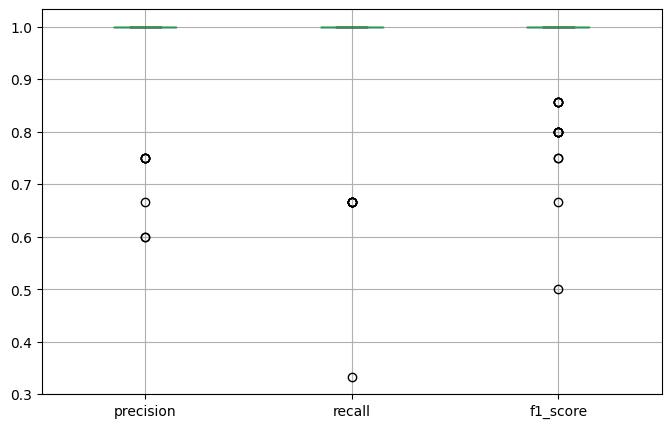

In [36]:
test_preds = grid.predict(dataset.x_test)
test_reports = DM.evaluate_predictions(dataset.t_test, test_preds, dataset.classes)

Étant donné le nombre élevé de classes (99), l'évaluation des performances pour chaque classe individuelle peut rapidement devenir impraticable. Pour obtenir une vue d'ensemble, nous analysons plutôt la moyenne des métriques à travers l'ensemble des classes. Globalement, notre modèle démontre une performance robuste, manifestant à la fois une précision et une justesse élevées.

Comme on peut le voir dans le boxplot, les prédictions sont parfaites (métriques à 1.0) pour la grande majorité des classes. Il y a cependant des classes pour lesquelles le modèle a moins bien performé. Regardons de quelles classes il s'agit.

In [37]:
bad_classes = test_reports.query('precision < 1.0 or recall < 1.0')
print(bad_classes)
print('Sum:', len(bad_classes))

                        precision    recall  f1_score
Betula_Pendula           0.600000  1.000000  0.750000
Magnolia_Heptapeta       0.750000  1.000000  0.857143
Magnolia_Salicifolia     1.000000  0.666667  0.800000
Quercus_Agrifolia        0.600000  1.000000  0.750000
Quercus_Canariensis      0.750000  1.000000  0.857143
Quercus_Castaneifolia    1.000000  0.666667  0.800000
Quercus_Crassipes        0.750000  1.000000  0.857143
Quercus_Greggii          1.000000  0.666667  0.800000
Quercus_Nigra            1.000000  0.666667  0.800000
Quercus_Palustris        0.750000  1.000000  0.857143
Quercus_Phillyraeoides   1.000000  0.666667  0.800000
Quercus_Pontica          1.000000  0.666667  0.800000
Quercus_Shumardii        0.666667  0.666667  0.666667
Salix_Intergra           1.000000  0.666667  0.800000
Sorbus_Aria              1.000000  0.333333  0.500000
Tilia_Oliveri            0.750000  1.000000  0.857143
Sum: 16


Pour évaluer les performances de notre modèle Adaboost, nous pouvons également utiliser une matrice de confusion pour visualiser les prédictions incorrectes sur l'ensemble de test. La matrice de confusion affiche les classifications réelles par rapport aux classifications prédites, permettant ainsi d'identifier les erreurs et les tendances de notre modèle.

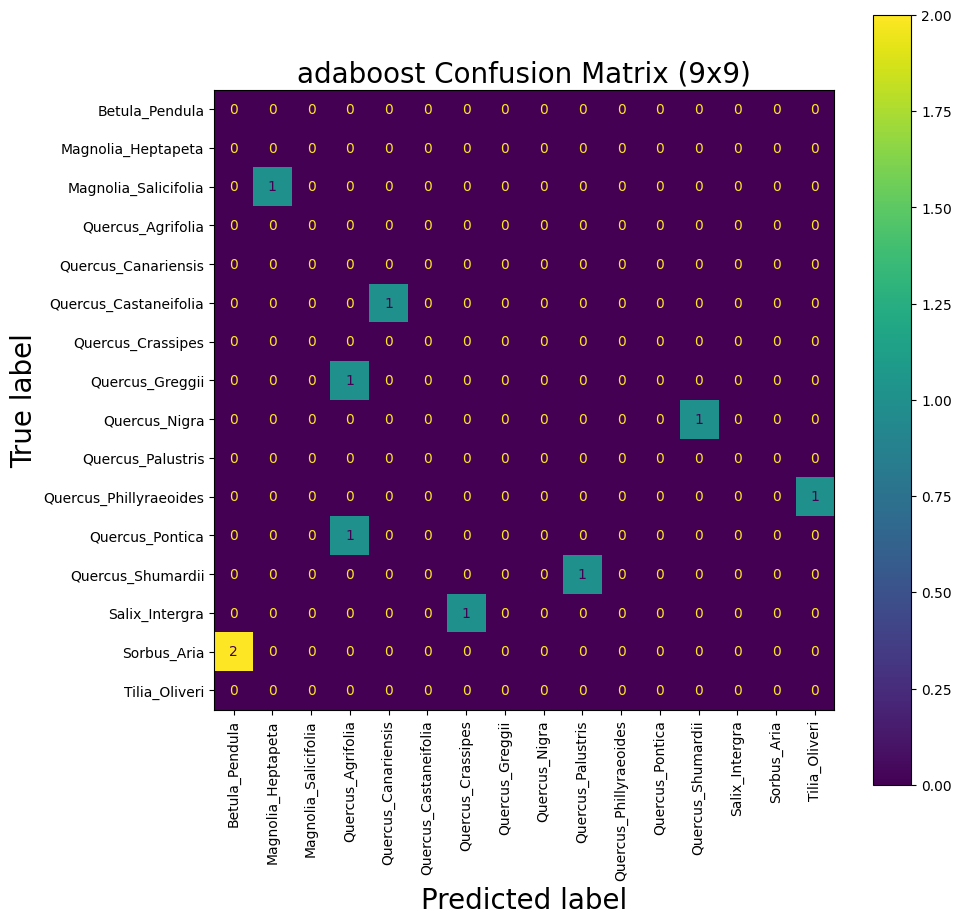

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get all the wrong predictions
bad_preds = DM.extract_bad_predictions(dataset.t_test, test_preds, labels=dataset.classes, ids=dataset.id_test)
matrix_size = len(bad_preds['True Class'].unique())

# Display them as a confusion matrix
display = ConfusionMatrixDisplay.from_predictions(bad_preds['True Class'], bad_preds['Predicted Class'], 
                                                  labels=bad_classes.index, xticks_rotation='vertical')
display.figure_.set_figwidth(10)
display.figure_.set_figheight(10)

# Ajustez la taille de la police des titres des axes
display.ax_.set_title(f'adaboost Confusion Matrix ({matrix_size}x{matrix_size})', fontsize=20)
display.ax_.xaxis.label.set_size(20)  # Ajustez la taille de la police pour l'axe des x
display.ax_.yaxis.label.set_size(20)  # Ajustez la taille de la police pour l'axe des y

plt.show()


Aucun schéma ou relation spécifique n'émerge clairement parmi les prédictions erronées. Il est donc probable que ces erreurs soient associées à des données où les caractéristiques sont moins nettement définies.

### Conclusion

Les paramètres optimaux pour notre modèle Adaboost un nombre d'estimateur assez grands,qui préférablement soient des arbres de décision, et un learning rate modeste. Avec ces hyperparamètres, le modèle performe extrêmement bien, avec des valeurs entre 96,5% et 97,5% pour les différentes métriques de performance, et ne semble donc ni sous-apprendre ni sur-apprendre.


Cependant, il est important de souligner que notre ensemble de données comporte un grand nombre de classes (99) et un nombre relativement faible de données par classe (seulement 10). De plus, notre ensemble de test ne comptait que 3 données par classe, ce qui est une quantité très limitée. Par conséquent, il est complexe d'affirmer si les résultats obtenus reflètent fidèlement les performances réelles du modèle.